In [1]:
import pandas as pd

df = df = pd.read_csv("data/training_data_ht2025.csv")
print('data shape: ', df.shape)
# print(df.info())

data shape:  (1600, 16)


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def preprocess(df):
    # 1. Convert the target to numeric: 1 = increase needed, 0 = low demand
    df['increase_stock_numeric'] = (df['increase_stock'] != 'low_bike_demand').astype(int)

    # 2. Define target
    y = df['increase_stock_numeric']

    # 3. Define features (drop original and numeric target columns)
    X = df.drop(columns=['increase_stock', 'increase_stock_numeric'])

    # 4. Standardize all features (important for fairness across models)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 5. Unified train/validation split (20%, same random_state for everyone)
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    return X_train, X_val, y_train, y_val

X_train, X_test, y_train, y_test = preprocess(df)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1280, 15) (320, 15) (1280,) (320,)


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# implementing kNN and find the best k value (in terms of accuracy)
# k : number of neighbors
best_k = 1
best_accuracy = 0
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_predict)
    print(f'k={k}, accuracy={accuracy}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print('-----------------------------------')
print(f'Best k: {best_k} with accuracy: {best_accuracy}')

k=1, accuracy=0.79375
k=2, accuracy=0.834375
k=3, accuracy=0.825
k=4, accuracy=0.83125
k=5, accuracy=0.821875
k=6, accuracy=0.8375
k=7, accuracy=0.825
k=8, accuracy=0.846875
k=9, accuracy=0.85
k=10, accuracy=0.865625
k=11, accuracy=0.859375
k=12, accuracy=0.865625
k=13, accuracy=0.85625
k=14, accuracy=0.8625
k=15, accuracy=0.85625
k=16, accuracy=0.8625
k=17, accuracy=0.85625
k=18, accuracy=0.853125
k=19, accuracy=0.853125
k=20, accuracy=0.85625
-----------------------------------
Best k: 10 with accuracy: 0.865625


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       270
           1       0.57      0.32      0.41        50

    accuracy                           0.86       320
   macro avg       0.73      0.64      0.66       320
weighted avg       0.83      0.86      0.84       320



<Figure size 600x400 with 0 Axes>

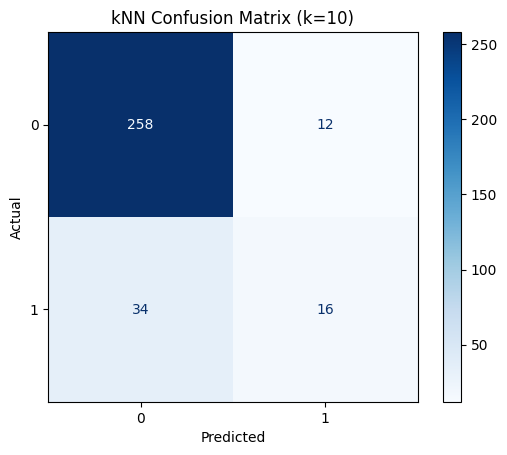

In [4]:
# Model evaluation  
import matplotlib.pyplot as plt

def write_report_and_plot_cm(y_test, y_predict, title='Confusion Matrix'):
    classification_report = metrics.classification_report(y_test, y_predict)
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)  
    print("Classification Report:\n", classification_report)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix).plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

write_report_and_plot_cm(y_test, y_predict, title=f'kNN Confusion Matrix (k={best_k})')

In [5]:
from sklearn.model_selection import GridSearchCV

# Let's perform hyperparameter tuning using GridSearchCV
params_to_optimized = {'n_neighbors': list(range(1, 21)),
               'weights': ['uniform', 'distance'],
               'metric': ['euclidean', 'manhattan', 'minkowski']}

knn_search_optimized = GridSearchCV(KNeighborsClassifier(), params_to_optimized, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
knn_search_optimized.fit(X_train, y_train)
print('Best score: ', knn_search_optimized.best_score_)
print('Best params: ', knn_search_optimized.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best score:  0.8765625
Best params:  {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


In [6]:
# Let's implement kNN with best params

knn_optimized = KNeighborsClassifier(n_neighbors=knn_search_optimized.best_params_['n_neighbors'],
                                     weights=knn_search_optimized.best_params_['weights'],
                                     metric=knn_search_optimized.best_params_['metric'])
knn_optimized.fit(X_train, y_train)
y_predict = knn_optimized.predict(X_test)
accuracy_optimized = metrics.accuracy_score(y_test, y_predict)
print(f'Optimized kNN accuracy: {accuracy_optimized}')


Optimized kNN accuracy: 0.86875


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       270
           1       0.61      0.44      0.51        50

    accuracy                           0.87       320
   macro avg       0.76      0.69      0.72       320
weighted avg       0.86      0.87      0.86       320



<Figure size 600x400 with 0 Axes>

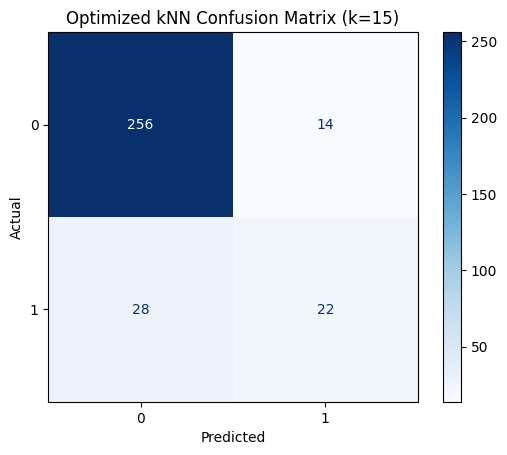

In [7]:
# Model evaluation  
write_report_and_plot_cm(y_test, y_predict, title=f'Optimized kNN Confusion Matrix (k={knn_search_optimized.best_params_["n_neighbors"]})') 

In [8]:
# conclusion
print('-----------------------------------')
print('conclusion:')
print(f'✅ Initial Accuracy : best k: {best_k} with accuracy: {best_accuracy}')
print(f'✅ Tuning kNN accuracy: best k: {knn_search_optimized.best_params_["n_neighbors"]} with accuracy: {accuracy_optimized}')
print(f'⚠️ Accuracy improvement: {accuracy_optimized - best_accuracy}, NOT SIGNIFICANT')

-----------------------------------
conclusion:
✅ Initial Accuracy : best k: 10 with accuracy: 0.865625
✅ Tuning kNN accuracy: best k: 15 with accuracy: 0.86875
⚠️ Accuracy improvement: 0.0031250000000000444, NOT SIGNIFICANT
